In [374]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from pywaffle import Waffle


# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid.inset_locator import InsetPosition
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={
'axes.facecolor': '#FFF9ED', 
'figure.facecolor': '#FFF9ED'
})

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import imblearn
from sklearn.utils import resample, class_weight
import xgboost as xgb
from sklearn import metrics


In [375]:
from matplotlib.colors import ListedColormap
color=['#364BA5', '#EE1E14']
custom = sns.set_palette(sns.color_palette(color))
my_cmap = ListedColormap(sns.color_palette(color).as_hex())


In [376]:
df = pd.read_csv('Churn_Modelling.csv')
df.drop('RowNumber', axis=1, inplace=True)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


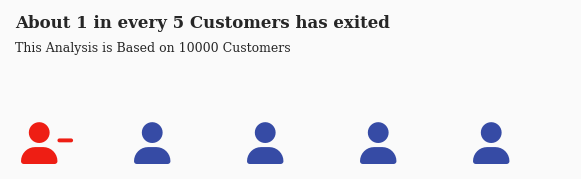

In [377]:
# Check the distribution of the data
background_color = '#fafafa'
# pywaffle library
data = {'left': 1, 'Stayed': 4}
fig = plt.figure(
    figsize=(4,2),
    dpi=150,
    facecolor=  background_color,
    FigureClass = Waffle,
    rows = 1,
    values = data,
    colors = [ '#EE1E14', '#364BA5'],
    legend = {'loc': 2, 'bbox_to_anchor': (1,1)},
    icons =  ['user-minus', 'user'],
    font_size = 20,
    vertical = True

    )
fig.text(0.035, 0.78, 'About 1 in every 5 Customers has exited', fontfamily='serif',
 fontsize = 8, fontweight = 'bold')
fig.text(0.035, 0.70, 'This Analysis is Based on 10000 Customers', fontfamily='serif',
fontsize = 6)
fig.gca().get_legend().remove()
fig.tight_layout()
plt.savefig('img/distribution.png')
plt.show()

# Exploratory Data Analysis and Visualization

The y variable is highly imbalanced. The number of customers that did not exit are ~80% while the ones that did are about 20%. This was expected given that it would be highly unlikely for a company to lose the same number of customers as it was keeping. <br>
The goal of this project is to create a machine learning model that predicts the customers that are likely to churn and therefore deal with their respective issues before they do so. <br>
The data being highly imbalanced will cause us problems in terms of recall and precision metrics. Therefore we will apply balancing techniques to the data before any machine learning model is fitted. However, we will start by exploring and cleaning our data.

We will drop additional columns 'customerId' and 'Surname' as I do not think they will be significant to our model

In [378]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

In [379]:
# Binning the credit score column
"""
300-579: Poor.
580-669: Fair.
670-739: Good.
740-799: Very good.
800-850: Excellent.
"""

cut_labels = ['Poor', 'Fair', 'Good', 'Very_Good', 'Excellent']
cut_bins = [300, 579, 669, 739, 799, 850]
df['CreditScore_bins'] = pd.cut(df['CreditScore'], bins = cut_bins, labels=cut_labels)


# Binning the age column
"""
18-25: Youth
26-40: Young Adults
41-64: Older Adults
65-100: Seniors

"""
cut_labels = ['Youth', 'Young_Adults', 'Older_Adults', 'Seniors']
cut_bins = [18, 25, 40, 64, 100]
df['Age_bins'] = pd.cut(df['Age'], bins = cut_bins, labels=cut_labels)


## Balance
The Balance column has values that range from 0 to 250898 shillings.

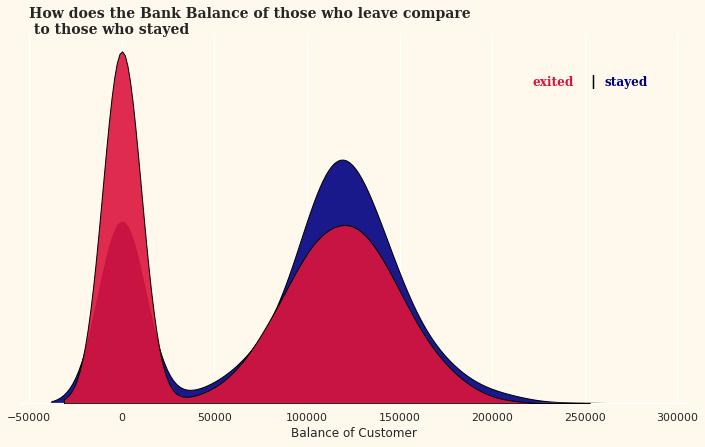

In [380]:
fig, axs = plt.subplots(1,1, figsize=(10,6))
axs.tick_params(axis='y', left=False)
axs.get_yaxis().set_visible(False)
for s in ['top', 'right', 'left']:
    axs.spines[s].set_visible(False)

y = df[df['Exited'] == 1]
n = df[df['Exited'] == 0]

sns.kdeplot(n['Balance'], ax = axs, color='crimson', shade=True, linewidth=1, ec='black',
alpha=0.9, zorder=3, legend=False)
sns.kdeplot(y['Balance'], ax = axs, color='navy', shade=True, linewidth=1, ec='black',
alpha=0.9, zorder=2, legend=False)

axs.set_xlabel('Balance of Customer', fontsize=12)

fig.text(0.05, 0.97, 'How does the Bank Balance of those who leave compare \n to those who stayed',
fontsize=14, fontweight='bold', fontfamily='serif')
fig.text(0.75, 0.85, 'exited', fontweight='bold', fontsize=12, color='crimson', fontfamily='serif')
fig.text(0.83, 0.85, '|', fontweight='bold', fontsize=14, color='black')
fig.text(0.85, 0.85, 'stayed', fontweight='bold', fontsize=12, color='navy', fontfamily='serif')

# fig.text(1.1, 0.80, 'Insight', fontsize=14, fontweight='bold',fontfamily='serif')
# fig.text(1.1, 0.45, 
# """
# The data appears to have a bimodal distribution. This reveals 
# to us that there are two different types of individuals represented 
# in the data. 
# * There is the first group with no balance in their accounts. This 
#   group has a higher proportion of people who stayed.
# * This second group represents individuals with a significant bank
#   balance in their account(100000 < x < 200000). This group has a higher
#   proportion of people leaving. Could it be that the bank is not satisfying
#   the needs of customers with high balances?
# """,
# fontsize=12, fontweight='light',fontfamily='serif'
# )
# l1 = lines.Line2D([1,1], [0,1], transform=fig.transFigure, figure=fig, color='black', lw=0.2)
# fig.lines.extend([l1])
# axs.tick_params(axis='both', which='major', labelsize=12)
# axs.tick_params(axis=u'both', which=u'both', length=0)


plt.tight_layout()
plt.savefig('img/Balance.png', bbox_inches='tight')
plt.show()

The data appears to have a bimodal distribution. This reveals 
to us that there are two different types of individuals represented 
in the data. 
* There is the first group with no balance in their accounts. This 
  group has a higher proportion of people who stayed.
* This second group represents individuals with a significant bank
  balance in their account(100000 < x < 200000). This group has a higher
  proportion of people leaving. Could it be that the bank is not satisfying
  the needs of customers with high balances?

## Analysis of Bank Customers

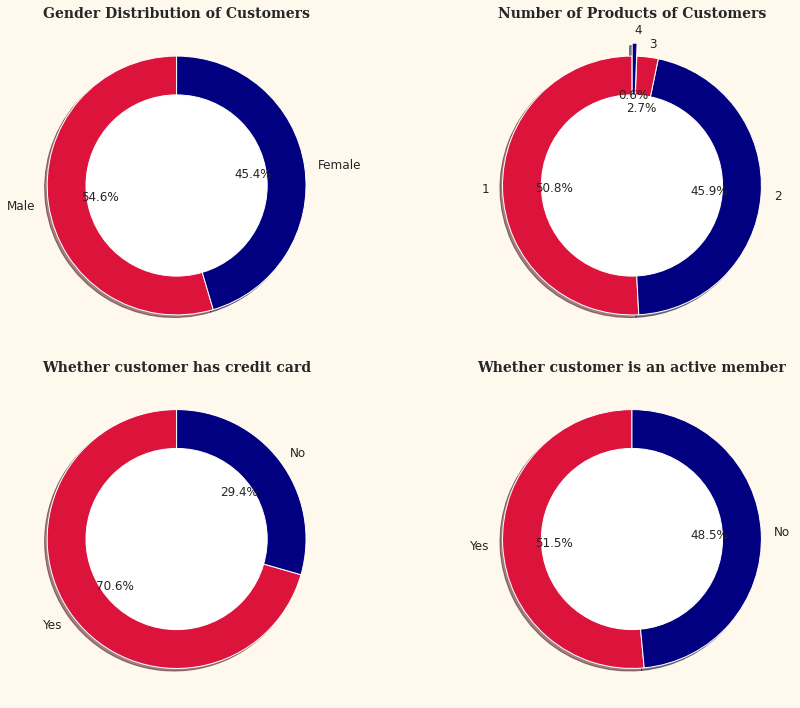

In [381]:
def donut_plot(df, col, title=None, ax=None, color=['crimson','navy'], labels = None, explode =None):
    data = df[col].value_counts()
    if labels is None:
        labels = data.index
    ax.pie(data, colors=color, autopct='%1.1f%%', shadow=True,
             startangle=90, labels=labels, textprops={'fontsize': 12},explode=explode)
    circle = plt.Circle((0,0), 0.7, color='white')
    ax.add_artist(circle)

    ax.set_title(title, fontsize=14, fontweight='bold', fontfamily='serif')
    plt.tight_layout()


fig, axs = plt.subplots(2,2, figsize=(24,10))


donut_plot(df, 'Gender', title='Gender Distribution of Customers', ax=axs[0,0])
donut_plot(df, 'NumOfProducts', title='Number of Products of Customers', ax=axs[0,1],
            explode=[0,0,0,0.1])
donut_plot(df, 'HasCrCard', title='Whether customer has credit card', ax=axs[1,0],
            labels = ['Yes', 'No'])
donut_plot(df, 'IsActiveMember', title='Whether customer is an active member', ax=axs[1,1],
            labels=['Yes', 'No'])
# plt.gcf().set_size_inches(15,10)
plt.tight_layout()




## How does the age of customers compare to their credit scores

Text(0.5, 0.98, 'Scatterplot on Age vs Credit Score')

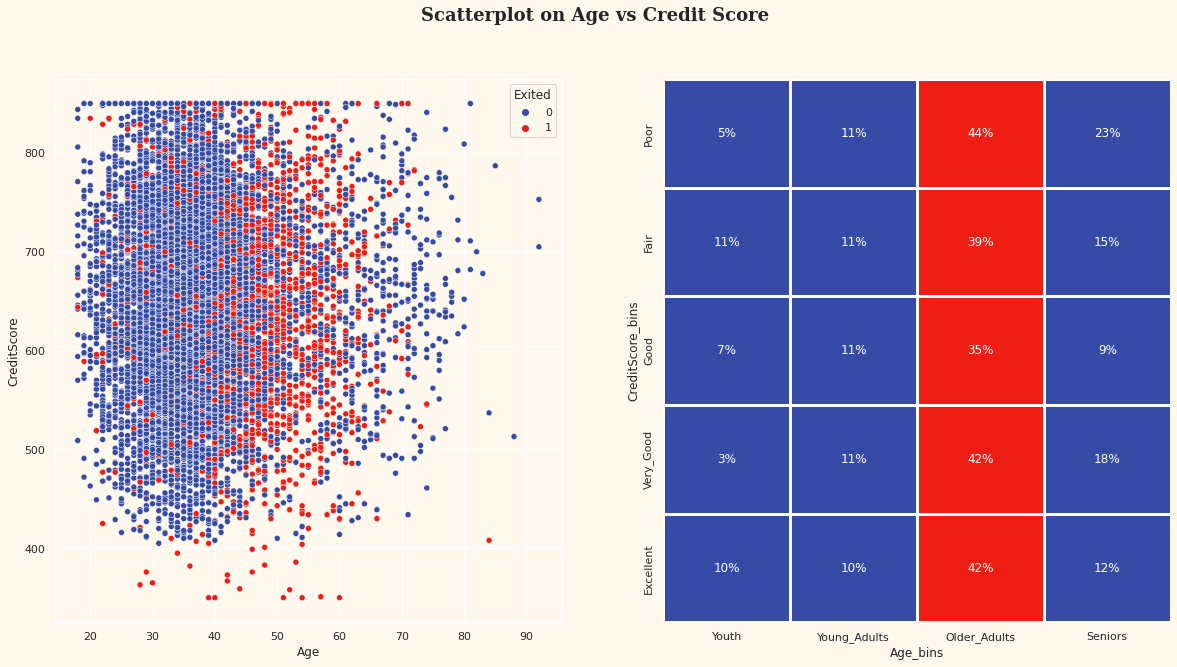

In [382]:
fig, axs = plt.subplots(1,2, figsize=(20,10))


# Create a scatterplot on age vs creditscore
sns.scatterplot(x='Age', y='CreditScore', data=df, hue='Exited', ax=axs[0], palette=custom)
df_heatmap = df.pivot_table(values='Exited', columns='Age_bins', index='CreditScore_bins', aggfunc=np.mean)
sns.heatmap(df_heatmap,  square=False, linewidth=2.5, cbar=False, annot=True, cmap = my_cmap,
            fmt='1.0%',vmax=.6, vmin=0.05,  annot_kws={'fontsize': 12}, ax=axs[1])
plt.suptitle('Scatterplot on Age vs Credit Score', fontsize=18, fontweight='bold', fontfamily='serif')



## Location and gender of the exited customers

Text(0.5, 1.0, 'Location and Gender of Exited Customers')

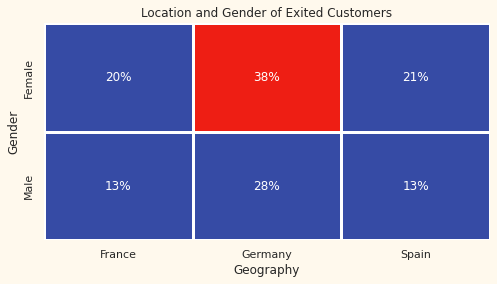

In [383]:
df_heatmap = df.pivot_table(values='Exited', index='Gender', columns='Geography', aggfunc=np.mean)
fig, axs = plt.subplots(1,1, figsize=(8,4))
sns.heatmap(df_heatmap,  square=False, linewidth=2.5, cbar=False, annot=True, cmap=my_cmap,
            fmt='1.0%',vmax=.6, vmin=0.05, ax=axs, annot_kws={'fontsize': 12})
plt.title('Location and Gender of Exited Customers')

Text(0.5, 0.98, 'Credit card usage by age')

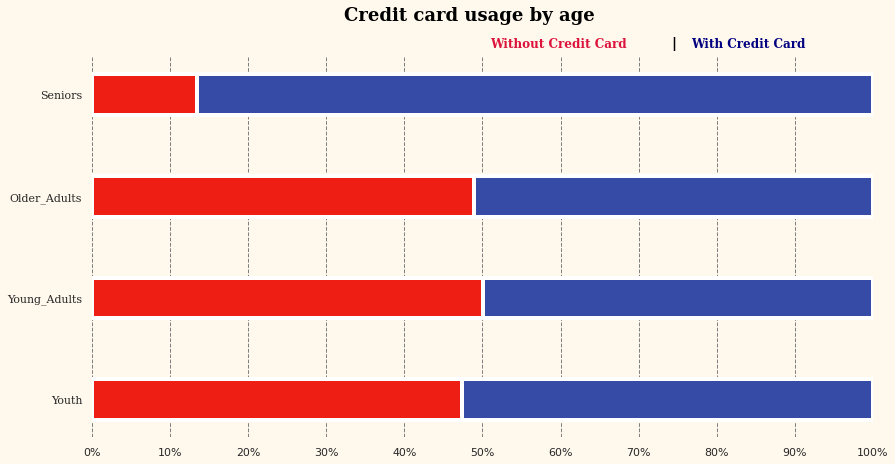

In [384]:
cross_tab_prop = pd.crosstab(
    index = df['Age_bins'],
    columns = df['IsActiveMember'], 
    normalize='index'
).sort_index(ascending=True)
labels = df['Age_bins'].tolist()
colors = [ '#EE1E14', '#364BA5']
title='Credit card usage by age'
fields = cross_tab_prop.columns.tolist()

fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plot bars
left = len(cross_tab_prop) * [0]

for idx, name in enumerate(fields):
    plt.barh(cross_tab_prop.index,
     cross_tab_prop[name],
      left = left, 
      height=0.4,
      linewidth =4,
      align = 'center',
      color=colors[idx])
    left = left + cross_tab_prop[name]

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(cross_tab_prop.index, fontfamily='serif', fontsize=11)
# # remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# format x ticks
xticks = np.arange(0,1.1,0.1)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
plt.xticks(xticks, xlabels)
ax.xaxis.grid(color='gray', linestyle='dashed')

fig.text(0.52, 0.90, 'Without Credit Card', fontweight='bold', fontsize=12, color='crimson', fontfamily='serif')
fig.text(0.70, 0.90, '|', fontweight='bold', fontsize=14, color='black')
fig.text(0.72, 0.90, 'With Credit Card', fontweight='bold', fontsize=12, color='navy', fontfamily='serif')
plt.suptitle(title, fontweight='bold', fontsize=18, color='black', fontfamily='serif')

## Correlation matrix

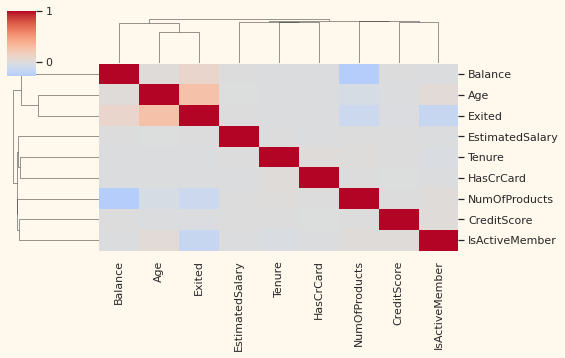

In [387]:
sns.clustermap(df.corr(method='kendall'),
                cbar=(-0.05, 0.8, 0.05, 0.18),
                cmap='coolwarm', 
                figsize=(8,5),
                center=0)

In [363]:
# Drop the columns we added
df.drop(['Age_bins', 'CreditScore_bins'], axis=1, inplace=True)


# Get dummies on categorical columns
cat_features = [col for col, dtype in df.dtypes.items() if dtype == 'object']
num_features = [col for col, dtype in df.dtypes.items() if dtype != 'object']

for col in cat_features:
    col_ohe = pd.get_dummies(df[col], prefix=col)
    df = pd.concat((df, col_ohe), axis=1).drop(col, axis=1)

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


# Data Modeling
When dealing with imbalanced datasets, novices usually fall into the metric trap. This is when they use simple metrics like 'accuracy_score' to evaluate their models. The classifier always ends up predicting the most common class without any analysis of the features, which will lead it to have a high accuracy rate, which will be an illusion. So it is often imperative to change the metric of evaluation into **Precision** or **Recall**.
* **Precision:** Refers to the number of true positives divided by all positive predictions. It is a measure of classifier's exactness. In short, how many of the predicted elements are relevant.
* **Recall:** Refers to the number of true positives divided by the number of positive values in the test data. In short, it refers to how many of the elements were actually selected.
* **F1 Score:** This is the weighted average of precision and recall.

We will first split our data to avoid data leakage.

In [364]:
# Split our data
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

df_test = pd.concat([X_test, y_test], axis=1)
df_train = pd.concat([X_train, y_train], axis=1)

The goal of all this would be to perform the balancing techniques on different train data, then test on the same test data. Here is an illustration of how a model would perform without any balancing

In [365]:
def model_eval(model=xgb.XGBClassifier(eval_metric='logloss')):
    # Fit the model
    model.fit(X_train, y_train)
    # make predictions
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    # Confusion matrix
    cf_matrix = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', cbar=False, fmt='g')
    return cf_matrix


              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1593
           1       0.70      0.48      0.57       407

    accuracy                           0.85      2000
   macro avg       0.79      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000



<AxesSubplot:>

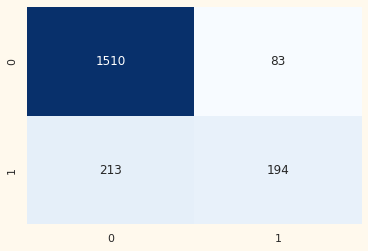

In [366]:
model_eval()

This model cannot handle the minority class. Even though it has an 80% accuracy, it simply predicted that all the data belonged to the majority class. This is why it is important to balance your data before any modeling. In the following section, I'll create datasets using various techniques.<br>
We will also use XGBoost classifier which is a shallow learning method that uses gradient boosting to build a sequence of classification trees which added together form an intelligent, flexible and robust predictive algorithm for any use cases. This makes it easier to interpret and explain. Given the severe class imbalance, it is good to use an algorithm like XGBoost that we know can scale up to a much larger sample size in the future


## Resampling
There are two ways of resampling your data: oversampling and undersampling<br>

![](img/Resampling.png)


We will start with undersampling

### Undersampling
This is the process of removing observations from a dataset to make it more representative of the population. This is done by randomly removing observations from the dataset. Here is the code to do that:

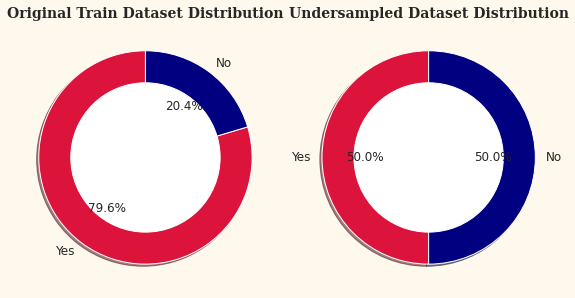

In [367]:
# Shuffle the dataset
shuffled_df = df_train.sample(frac=1, random_state=4)

# Put the data into separate datasets
exited_df = shuffled_df[shuffled_df['Exited'] == 1]

# Randomly select observations from the majority class
stayed_df = shuffled_df.loc[shuffled_df['Exited'] == 0].sample(n=len(exited_df), random_state=0)

# Concatenate both dataframes
undersampled_df = pd.concat([exited_df, stayed_df])

# Plot the data now
fig, axs = plt.subplots(1,2, figsize=(8,5))
donut_plot(df_train, 'Exited', title='Original Train Dataset Distribution', ax=axs[0], labels=['Yes', 'No'])
donut_plot(undersampled_df, 'Exited', title='Undersampled Dataset Distribution', ax=axs[1], labels=['Yes', 'No'])
plt.tight_layout()

### Oversampling
This is done by randomly replicating samples from the minority class until the data is balanced. Here is the code to do that: 

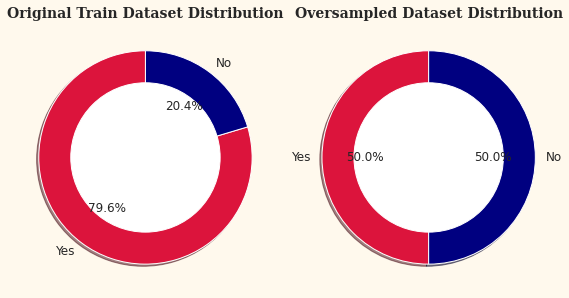

In [368]:
# Put the data in different datasets
stayed_df = shuffled_df[shuffled_df['Exited'] == 0]

# Randomly select observations from the minority class with replacement
exited_df = resample(shuffled_df.loc[shuffled_df['Exited'] == 1],
                    n_samples=len(stayed_df), 
                    random_state=0,
                    replace=True)

# Concatenate both dataframes
oversampled_df = pd.concat([exited_df, stayed_df])

# Plot the data now
fig, axs = plt.subplots(1,2, figsize=(8,5))
donut_plot(df_train, 'Exited', title='Original Train Dataset Distribution', ax=axs[0], labels=['Yes', 'No'])
donut_plot(oversampled_df, 'Exited', title='Oversampled Dataset Distribution', ax=axs[1], labels=['Yes', 'No'])
plt.tight_layout()

## SMOTE - OverSampling
Smote refers to Synthetic Minority Over-sampling Technique. Here is how it works:
* First, SMOTE chooses a minority class data point.
* It then uses part of the KNN method to find other minority class data points nearby
* It then creates synthetic minority samples that lie on the lines connecting the chosen minority data point and the nearby minority data points.

This method is effective because the synthetic data generated are relatively close with the feature space of the minority class, thus adding new "information"on the data unlike the original oversampling method.<br>
One of the weaknesses is that this method assumes that the best representation for the minority class is a continuousgeometric shape which is not always the case.<br>

![](img/SMOTE.png)

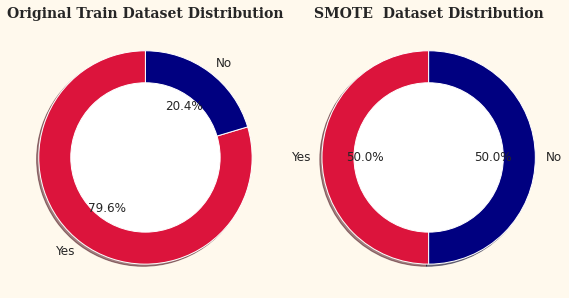

In [369]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=1.0, random_state=42)
X_train1, y_train1 = smote.fit_sample(X_train, y_train)

SMOTE_df = pd.concat([X_train1, y_train1], axis=1)
# Plot the data now
fig, axs = plt.subplots(1,2, figsize=(8,5))
donut_plot(df_train, 'Exited', title='Original Train Dataset Distribution', ax=axs[0], labels=['Yes', 'No'])
donut_plot(SMOTE_df, 'Exited', title='SMOTE  Dataset Distribution', ax=axs[1], labels=['Yes', 'No'])
plt.tight_layout()

## SMOTE-Tomek Links
This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek Links from the majority class. i.e samples of data from the majority class that is closest with the minority class data). The process of SMOTE-Tomek  links is as follows.
* **(Start of SMOTE)** Choose random data from the minority class
* Calculate the distance between the random data and its k nearest neighbors
* Multiplying the difference with a random number btw 0 and 1, then add the result to the minority class as a synthetic data point
* Repeat steps 2 and 3 until the number of synthetic data points is equal to the number of minority class data points **(End of SMOTE)**
* **(Start of Tomek Links)** Choose random data from the majority class
* If the random data's nearest neighbor is the data from the minority class i.e the tomek link, then remove the tomek link.

![](img/Tomek.png)



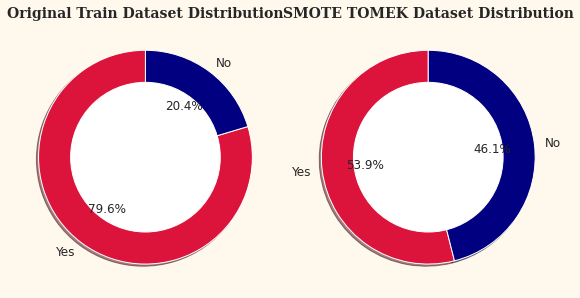

In [370]:
# Define the SMOTE-Tomek links
# We will configure the combination to only remove links from the majority class
smote_tomek = imblearn.combine.SMOTETomek(
    tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'),
    random_state=42
)
X_train1, y_train1  = smote_tomek.fit_sample(X_train, y_train)

TOMEK_df = pd.concat([X_train1, y_train1], axis=1)

# Plot the data now
fig, axs = plt.subplots(1,2, figsize=(8,5))
donut_plot(df_train, 'Exited', title='Original Train Dataset Distribution', ax=axs[0], labels=['Yes', 'No'])
donut_plot(TOMEK_df, 'Exited', title='SMOTE TOMEK Dataset Distribution', ax=axs[1], labels=['Yes', 'No'])
plt.tight_layout()

### NearMiss Algorithm - Undersampling
This is an undersampling technique. It aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process

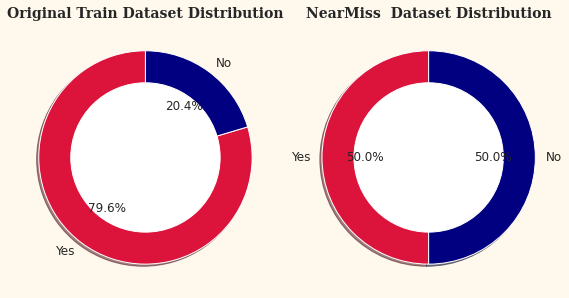

In [371]:
nr = imblearn.under_sampling.NearMiss()
X_train1, y_train1 = nr.fit_sample(X_train, y_train)

Nearmiss_df = pd.concat([X_train1, y_train1], axis=1)
# Plot the data now
fig, axs = plt.subplots(1,2, figsize=(8,5))
donut_plot(df_train, 'Exited', title='Original Train Dataset Distribution', ax=axs[0], labels=['Yes', 'No'])
donut_plot(Nearmiss_df, 'Exited', title='NearMiss  Dataset Distribution', ax=axs[1], labels=['Yes', 'No'])
plt.tight_layout()

We will now evaluate our datasets using the same model and find out which balancing technique works best in our case. As I said, we will use the xgb classifier.

In [372]:
model = xgb.XGBClassifier(eval_metric='logloss')

datasets = {
    # Undersampling techniques
    ##Simple Undersampling
    'simple_undersampling': {'dataset': undersampled_df},
    'nearmiss': {'dataset': Nearmiss_df},

    # Oversampling techniques
    'tomek': {'dataset': TOMEK_df},
    'simple_oversampling': {'dataset': oversampled_df},
    'smote': {'dataset': SMOTE_df}

    
}
results = {
        'Dataset':[], 'Accuracy': [],
        'Roc_auc_score': [],'Precision':[],'Recall': [],'f1_score': []
        }
def evaluate(classifier, datasets):   
    
    for label in datasets.keys(): 
        # print(data.head())
        results['Dataset'].append(label)
        data = datasets[label]['dataset']
        # Split the balanced dataset 
        X_train = data.drop('Exited', axis=1)
        y_train = data['Exited']
        classifier.fit(X_train, y_train)
        # Remember we are using the same test data
        y_test = classifier.predict(X_test)
        # Append accuracy
        results['Accuracy'].append(metrics.accuracy_score(y_test, y_pred))
        # ROC score
        results['Roc_auc_score'].append(metrics.roc_auc_score(y_test, y_pred))
        # Precision
        results['Precision'].append(metrics.precision_score(y_test, y_pred))
        # Recall
        results['Recall'].append(metrics.recall_score(y_test, y_pred))
        # f1_score
        results['f1_score'].append(metrics.f1_score(y_test, y_pred))
        print(f"{label} DONE!!")

evaluate(model, datasets)

results = pd.DataFrame(results)
results.sort_values(by='f1_score', ascending=False).\
style.background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy', 'Recall','Roc_auc_score']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['f1_score', 'Precision'])

simple_undersampling DONE!!
nearmiss DONE!!
tomek DONE!!
simple_oversampling DONE!!
smote DONE!!


,Dataset,Accuracy,Roc_auc_score,Precision,Recall,f1_score
2,tomek,1.000000,1.000000,1.000000,1.000000,1.000000
4,smote,0.933500,0.911615,0.794749,0.876316,0.833542
3,simple_oversampling,0.896500,0.839391,0.789976,0.735556,0.761795
0,simple_undersampling,0.833000,0.765730,0.897375,0.563718,0.692449
1,nearmiss,0.496500,0.617858,0.926014,0.284457,0.435222


In conclusion, everyone should know that the overall performance of ML models built on imbalanced datasets, will be constrained by its ability to predict rare and minority points. Identifying and resolving the imbalance of those points is crucial to the quality and performance of the generated models.